In [ ]:
# 1_install_and_mount.ipynb cell
!pip install rasterio tqdm
# torch is usually preinstalled on Colab GPU runtimes; if not, uncomment the next line:
# !pip install torch torchvision

from google.colab import drive
drive.mount('/content/drive')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 38.4 MB/s eta 0:00:00
Mounted at /content/drive


In [ ]:
# 2_utils.py cell
import os, re
from datetime import datetime
import numpy as np
import rasterio
from rasterio.errors import RasterioIOError
from tqdm import tqdm

def extract_date_from_tif(path):
    """Try to read acquisition date from common metadata keys or filename.
       Returns a datetime.date object, or None if not found."""
    try:
        with rasterio.open(path) as src:
            tags = src.tags()
            # common keys
            for key in ("DATE_ACQUIRED","ACQUISITION_DATE","SENSING_TIME","TIFFTAG_DATETIME","ACQUISITION"):
                if key in tags and tags[key]:
                    s = tags[key]
                    # try multiple formats
                    for fmt in ("%Y-%m-%d", "%Y:%m:%d %H:%M:%S", "%Y-%m-%dT%H:%M:%S", "%Y%m%d", "%Y-%m-%d %H:%M:%S"):
                        try:
                            dt = datetime.fromisoformat(s) if 'T' in s else datetime.strptime(s, fmt)
                            return dt.date()
                        except Exception:
                            pass
            # try band descriptions (some stores per-band tags)
            descr = src.descriptions
            if descr:
                # sometimes date appears in description
                for d in descr:
                    if d:
                        m = re.search(r'(\d{4}-\d{2}-\d{2})', d)
                        if m:
                            return datetime.strptime(m.group(1), "%Y-%m-%d").date()
    except RasterioIOError:
        pass

    # fallback to filename patterns (YYYYMMDD or YYYY-MM-DD)
    fname = os.path.basename(path)
    m = re.search(r'(\d{4}-\d{2}-\d{2})', fname)
    if m:
        return datetime.strptime(m.group(1), "%Y-%m-%d").date()
    m = re.search(r'(\d{8})', fname)
    if m:
        return datetime.strptime(m.group(1), "%Y%m%d").date()
    return None

def detect_cloud_band(path, sample_pixels=5000):
    """Heuristic detection: looks for band descriptions containing 'cloud' or bands with binary values {0,1} or {0,255}."""
    try:
        with rasterio.open(path) as src:
            # descriptions first
            if src.descriptions:
                for i, d in enumerate(src.descriptions):
                    if d and ("cloud" in d.lower() or "qa" in d.lower() or "mask" in d.lower() or "fmask" in d.lower()):
                        return i+1  # rasterio bands are 1-indexed
            # otherwise inspect each band's statistics (sample)
            bands = src.count
            height = src.height; width = src.width
            # sample some pixels to check discrete values
            for i in range(1, bands+1):
                try:
                    arr = src.read(i, window=rasterio.windows.Window(0, 0, min(width, 200), min(height, 200)))
                except Exception:
                    arr = src.read(i)
                uniq = np.unique(arr)
                if len(uniq) <= 4:  # likely mask-like
                    # values commonly 0/1 or 0/255 etc
                    return i
    except Exception as e:
        print("detect_cloud_band error", e)
    return None

def read_tif_all_bands(path):
    with rasterio.open(path) as src:
        arr = src.read().astype(np.float32)  # shape (bands, H, W)
        profile = src.profile
        desc = src.descriptions
    return arr, profile, desc


In [ ]:
# 3_build_sequence.py cell
import numpy as np
import torch
import glob
import os
from datetime import date

def build_sequence_from_folder(folder, target_idx=None, num_steps=None, cloud_band_override=None, scale_by=None):
    """Scans folder for *.tif, extracts dates, sorts, builds one time series example.
       Returns: dict with numpy arrays:
         T: (t, c_in, H, W)
         Mx: (t, 1, H, W)
         Cx: (t, 2, H, W)  # if only one cloud band found, second channel zeros
         delta_days: (t, 1, 1, 1)
         My: (1, 1, H, W)
         Cy: (1, 2, H, W)
         meta: profile
    """
    tifs = sorted(glob.glob(os.path.join(folder, "*.tif")))
    if len(tifs)==0:
        raise FileNotFoundError("No tifs in folder: " + folder)
    # extract dates
    files_dates = []
    for p in tifs:
        d = extract_date_from_tif(p)
        files_dates.append((p, d))
    # remove those without date (or put at start)
    files_dates = sorted(files_dates, key=lambda x: (x[1] is None, x[1] if x[1] is not None else date.min))
    paths = [p for p,d in files_dates]
    dates = [d for p,d in files_dates]
    # target default: last (latest)
    if target_idx is None:
        idx_target = len(paths)-1
    else:
        idx_target = target_idx
    target_path = paths[idx_target]
    target_date = dates[idx_target]
    # select previous steps (exclude target)
    seq_paths = [p for i,p in enumerate(paths) if i!=idx_target]
    seq_dates = [d for i,d in enumerate(dates) if i!=idx_target]
    if num_steps is not None:
        # pick the num_steps closest to target (by date)
        pairs = list(zip(seq_paths, seq_dates))
        # compute absolute day diff (missing dates are placed far)
        def day_diff(pair):
            p,d = pair
            if d is None or target_date is None:
                return float('inf')
            return abs((target_date - d).days)
        pairs = sorted(pairs, key=day_diff)[:num_steps]
        seq_paths, seq_dates = zip(*pairs)
        seq_paths = list(seq_paths); seq_dates=list(seq_dates)

    # read target image (used for My,Cy)
    arr_t, prof_t, desc_t = read_tif_all_bands(target_path)
    # detect cloud band (global override allowed)
    cband = cloud_band_override if cloud_band_override is not None else detect_cloud_band(target_path)
    # NOTE: we assume cloud band is present in all files at same band index
    # Build arrays
    T_list=[]; Mx_list=[]; Cx_list=[]; delta_days=[]
    for p,d in zip(seq_paths, seq_dates):
        arr, profile, desc = read_tif_all_bands(p)  # arr shape (bands, H, W)
        # if cloud band detected, separate it
        if cband is not None and cband <= arr.shape[0]:
            cloud = arr[cband-1]  # (H,W)
            # the rest as spectral channels
            others = np.delete(arr, cband-1, axis=0)
        else:
            # fallback: take last band as cloud candidate only if binary-like
            cloud = np.zeros_like(arr[0])
            others = arr
        # Missingness mask
        nodata = profile.get('nodata', None)
        if nodata is not None:
            Mx = (~np.isclose(others, nodata)).all(axis=0).astype(np.float32)[np.newaxis,:,:]
        else:
            # assume all present; but set missing where NaN
            mask = ~np.isnan(others).any(axis=0)
            Mx = mask.astype(np.float32)[np.newaxis,:,:]
        # Normalize spectral bands (heuristic)
        if scale_by is None:
            # if band values look scaled (max>1000), divide by max (common for Landsat scaled to 10000)
            maxv = np.nanmax(others)
            if maxv > 1000:
                others_norm = others / float(maxv)
            else:
                # min-max normalize per band (safe)
                others_norm = np.zeros_like(others)
                for b in range(others.shape[0]):
                    band = others[b].astype(np.float32)
                    mn, mx = np.nanmin(band), np.nanmax(band)
                    if mx>mn:
                        others_norm[b] = (band-mn)/(mx-mn)
                    else:
                        others_norm[b] = band
        else:
            others_norm = others / float(scale_by)
        # Cloud mask channels: try to make (2, H, W)
        # Heuristic: if cloud values are {0,1} or {0,255} interpret 1/255 as cloud
        unique = np.unique(cloud)
        cloud_ch1 = (cloud>0).astype(np.float32)  # primary
        cloud_ch2 = np.zeros_like(cloud_ch1)  # placeholder second channel
        Cx = np.stack([cloud_ch1, cloud_ch2], axis=0)
        T_list.append(others_norm)
        Mx_list.append(Mx)
        Cx_list.append(Cx)
        # delta days
        if (target_date is None) or (d is None):
            delta_days.append(np.array([9999.0], dtype=np.float32))
        else:
            delta_days.append(np.array([abs((target_date - d).days)], dtype=np.float32))
    # stack
    T = np.stack(T_list, axis=0)       # (t, c_in, H, W)
    Mx = np.stack(Mx_list, axis=0)     # (t, 1, H, W)
    Cx = np.stack(Cx_list, axis=0)     # (t, 2, H, W)
    delta_days = np.stack(delta_days, axis=0).astype(np.float32)  # (t,1)
    # target masks: build My, Cy from target arr
    if cband is not None and cband <= arr_t.shape[0]:
        cloud_t = arr_t[cband-1]
        other_t = np.delete(arr_t, cband-1, axis=0)
    else:
        cloud_t = np.zeros_like(arr_t[0])
        other_t = arr_t
    if prof_t.get('nodata', None) is not None:
        My = (~np.isclose(other_t, prof_t['nodata'])).all(axis=0).astype(np.float32)[np.newaxis,:,:]
    else:
        My = (~np.isnan(other_t).any(axis=0)).astype(np.float32)[np.newaxis,:,:]
    Cy = np.stack([(cloud_t>0).astype(np.float32), np.zeros_like(cloud_t)], axis=0)[np.newaxis,:,:,:]  # (1,2,H,W)

    return {
        "T": T.astype(np.float32),
        "Mx": Mx.astype(np.float32),
        "Cx": Cx.astype(np.float32),
        "delta_days": delta_days.astype(np.float32),
        "My": My.astype(np.float32),
        "Cy": Cy.astype(np.float32),
        "profile": prof_t,
        "target_path": target_path,
        "seq_paths": seq_paths
    }


In [ ]:
# 4_algo1_module.py cell
import torch
import torch.nn as nn
import torch.nn.functional as F

class Algo1(nn.Module):
    def __init__(self, c_in, cond_channels=3, hidden_dim=32):
        """
        c_in: number of spectral channels in T
        cond_channels: channels in conditional input (My + Cy) => default 1 + 2 = 3
        hidden_dim: number of output feature maps per time step
        """
        super().__init__()
        self.hidden_dim = hidden_dim
        # combine: (c_in) + (1 for missingness) + (2 for cloud)
        self.point_conv_combine = nn.Conv2d(c_in + 1 + 2, hidden_dim, kernel_size=1)
        # cond embedding conv to hidden dim
        self.point_conv_cond = nn.Conv2d(cond_channels, hidden_dim, kernel_size=1)
        # spatial conv 3x3 then reduce back to hidden dim via 1x1
        self.conv3 = nn.Conv2d(hidden_dim, 64, kernel_size=3, padding=1)
        self.point_conv_out = nn.Conv2d(64, hidden_dim, kernel_size=1)
        # small scale param for delta normalization (learnable)
        self.register_parameter("delta_scale", nn.Parameter(torch.tensor(30.0)))  # divide days by ~30 (months)

    def forward(self, T, Mx, Cx, delta_days, My=None, Cy=None):
        """
        T: [B, t, c_in, H, W]
        Mx: [B, t, 1, H, W]
        Cx: [B, t, 2, H, W]
        delta_days: [B, t, 1]  (days)
        My: [B, 1, H, W]  (or None)
        Cy: [B, 2, H, W]  (or None)
        Returns: X [B, t, hidden_dim, H, W]
        """
        B, t, c_in, H, W = T.shape
        # flatten time into batch for conv ops: shape => [B*t, c, H, W]
        T_flat = T.reshape(B*t, c_in, H, W)
        Mx_flat = Mx.reshape(B*t, 1, H, W)
        Cx_flat = Cx.reshape(B*t, 2, H, W)

        # normalize delta_days -> decay in (0,1]
        # delta_days shape [B,t,1] -> (B*t, 1)
        delta = delta_days.reshape(B*t, 1)
        delta_norm = delta / (torch.clamp(self.delta_scale, min=1e-6))  # e.g. months by default
        # decay = exp(-ReLU(delta_norm))
        decay = torch.exp(-F.relu(delta_norm)).view(B*t, 1, 1, 1)  # broadcastable to H,W

        Mx_decay = Mx_flat * decay  # [B*t,1,H,W]

        # combine features per time-step
        combined = torch.cat([T_flat, Mx_decay, Cx_flat], dim=1)  # [B*t, c_in+1+2, H, W]
        x = self.point_conv_combine(combined)  # [B*t, hidden_dim, H, W]

        # conditional input (My,Cy) is only available in training; if present, broadcast & add
        if (My is not None) and (Cy is not None):
            # My [B,1,H,W], Cy [B,2,H,W] -> cond [B,3,H,W]
            cond = torch.cat([My, Cy], dim=1)  # [B,3,H,W]
            cond_feat = self.point_conv_cond(cond)  # [B, hidden_dim, H, W]
            # repeat for each time step
            cond_feat_rep = cond_feat.unsqueeze(1).repeat(1, t, 1, 1, 1).reshape(B*t, self.hidden_dim, H, W)
            x = x + cond_feat_rep

        # spatial conv
        x = self.conv3(F.mish(x))
        x = self.point_conv_out(F.mish(x))  # [B*t, hidden_dim, H, W]

        # reshape back to [B, t, hidden_dim, H, W]
        out = x.reshape(B, t, self.hidden_dim, H, W)
        return out


In [ ]:
print("Raw My shape from seq:", seq["My"].shape)  # should be (1,H,W)
print("Raw Cy shape from seq:", seq["Cy"].shape)  # should be (1,2,H,W) or (2,H,W)


Raw My shape from seq: (1, 288, 288)
Raw Cy shape from seq: (1, 2, 288, 288)


In [ ]:
# Target masks
My = torch.from_numpy(seq["My"]).to(torch.float32)   # should become [1,H,W]
Cy = torch.from_numpy(seq["Cy"]).to(torch.float32)   # should become [2,H,W]

# Add batch dim
if My.ndim == 3:   # (1,H,W)
    My = My.unsqueeze(0)   # -> [B,1,H,W]
if Cy.ndim == 3:   # (2,H,W)
    Cy = Cy.unsqueeze(0)   # -> [B,2,H,W]
elif Cy.ndim == 4 and Cy.shape[0] == 1:
    # Already has batch dim (1,2,H,W) — leave as is
    pass


In [ ]:
print("Final My shape:", My.shape)  # should be [B,1,H,W]
print("Final Cy shape:", Cy.shape)  # should be [B,2,H,W]


Final My shape: torch.Size([1, 1, 288, 288])
Final Cy shape: torch.Size([1, 2, 288, 288])


In [ ]:
# 5_run_example_final.py
import torch

data_folder = "/content/drive/MyDrive/GEE_Patches_ALL_Bands"  # <<--- change this
seq = build_sequence_from_folder(data_folder, num_steps=6)

# Print the paths of the sequence images
print("Sequence image paths:", seq["seq_paths"])

# Time series inputs
T = torch.from_numpy(seq["T"])[None].to(torch.float32)      # [B, t, c_in, H, W]
Mx = torch.from_numpy(seq["Mx"])[None].to(torch.float32)    # [B, t, 1, H, W]
Cx = torch.from_numpy(seq["Cx"])[None].to(torch.float32)    # [B, t, 2, H, W]
delta = torch.from_numpy(seq["delta_days"])[None].to(torch.float32)  # [B, t, 1]

# Target masks (handle shapes safely)
My = torch.from_numpy(seq["My"]).to(torch.float32)   # could be (1,H,W) or (1,1,H,W)
Cy = torch.from_numpy(seq["Cy"]).to(torch.float32)   # could be (2,H,W) or (1,2,H,W)

# Ensure correct shapes
if My.ndim == 3:        # (1,H,W)
    My = My.unsqueeze(0)  # -> [B,1,H,W]
elif My.ndim == 4 and My.shape[0] == 1:
    pass  # already [B,1,H,W]

if Cy.ndim == 3:        # (2,H,W)
    Cy = Cy.unsqueeze(0)  # -> [B,2,H,W]
elif Cy.ndim == 4 and Cy.shape[0] == 1:
    pass  # already [B,2,H,W]

print("Final My shape:", My.shape)  # expect [1,1,H,W]
print("Final Cy shape:", Cy.shape)  # expect [1,2,H,W]

# Device + model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)
model = Algo1(c_in=T.shape[2]).to(device)

# Move to device
T, Mx, Cx, delta, My, Cy = [x.to(device) for x in [T, Mx, Cx, delta, My, Cy]]

# Forward pass
with torch.no_grad():
    out = model(T, Mx, Cx, delta, My=My, Cy=Cy)

print("Algo1 output shape:", out.shape)  # [B, t, hidden_dim, H, W]

Sequence image paths: ['/content/drive/MyDrive/GEE_Patches_ALL_Bands/history_patch_allbands_summer_1.tif', '/content/drive/MyDrive/GEE_Patches_ALL_Bands/history_patch_allbands_summer_10.tif', '/content/drive/MyDrive/GEE_Patches_ALL_Bands/history_patch_allbands_summer_11.tif', '/content/drive/MyDrive/GEE_Patches_ALL_Bands/history_patch_allbands_summer_12.tif', '/content/drive/MyDrive/GEE_Patches_ALL_Bands/history_patch_allbands_summer_13.tif', '/content/drive/MyDrive/GEE_Patches_ALL_Bands/history_patch_allbands_summer_14.tif']
Final My shape: torch.Size([1, 1, 288, 288])
Final Cy shape: torch.Size([1, 2, 288, 288])
device: cpu
Algo1 output shape: torch.Size([1, 6, 32, 288, 288])


(np.float64(-0.5), np.float64(287.5), np.float64(287.5), np.float64(-0.5))

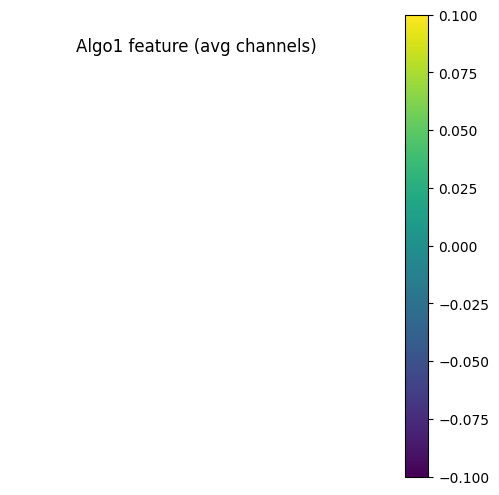

In [ ]:
# 6_visualize.py cell
import matplotlib.pyplot as plt
feat = out[0, 0].cpu().numpy()  # first batch, first time step -> (hidden_dim, H, W)
img = feat.mean(axis=0)  # average channels -> (H,W)
plt.figure(figsize=(6,6)); plt.imshow(img, cmap='viridis'); plt.colorbar(); plt.title("Algo1 feature (avg channels)")
plt.axis('off')
